In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [38]:
# Load dataset from CSV file
file_path = "dataset.csv"  # Replace with the actual file path
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(df.head())

  Corpus                                         Tweet Text  Stance Foundation
0    EVM  #EVMs are easy to manipulate . This was demons...       1   Fairness
1    CAA                    Congratulations\r\nAa gya  #CAA       1    Loyalty
2    CAA  My dear Indian muslims we are 35 crores of pop...      -1    Loyalty
3    CAA  This guy was part of anti Hindu protests in th...       1  Authority
4    CAA  Woman protester breaks down while speaking to ...       0       Care


In [88]:
# Find the number of rows for each unique value in the first column
class_counts = df.iloc[:, 0].value_counts()

# Print the counts for each class
print("Number of rows for each class:")
print(class_counts)

# Print the total number of rows
total_rows = df.shape[0]
print("\nTotal number of rows:", total_rows)

Number of rows for each class:
Corpus
CAA                     207
UCC                     190
EVM                     181
LGBTQ                   173
Animal Sacrifices       166
Anti Conversion Laws    162
Brain Drain             148
Name: count, dtype: int64

Total number of rows: 1227


In [72]:
# Preprocess the data
X = df['Tweet Text']
y = df['Stance']+1

In [73]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [74]:
# TF-IDF Vectorizer and Logistic Regression for TF-IDF Model
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)



In [75]:
tfidf_model = LogisticRegression(max_iter=1000)
tfidf_model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [76]:
# Predictions with TF-IDF
y_pred_tfidf = tfidf_model.predict(X_test_tfidf)

In [51]:
# Train-Test Split for bert
# y = df['Stance']+1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [52]:
# BERT Model Setup
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

In [53]:
# Initialize the tokenizer and BERT model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
# Preparing DataLoader for BERT
MAX_LEN = 128
train_dataset = CustomDataset(X_train.tolist(), y_train.tolist(), tokenizer, MAX_LEN)
test_dataset = CustomDataset(X_test.tolist(), y_test.tolist(), tokenizer, MAX_LEN)


In [55]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

In [56]:
# BERT Model Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)
optimizer = torch.optim.Adam(bert_model.parameters(), lr=2e-5)

In [57]:
# Training the BERT model (simplified for demonstration)
bert_model.train()
for epoch in range(2):  # Number of epochs
    loop = tqdm(train_loader, leave=True)
    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = bert_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        loss.backward()
        optimizer.step()

100%|██████████| 54/54 [19:03<00:00, 21.17s/it]


In [58]:
# BERT Model Evaluation
bert_model.eval()
predictions, true_labels = [], []


In [59]:
for batch in test_loader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['label'].to(device)
    
    with torch.no_grad():
        outputs = bert_model(input_ids, attention_mask=attention_mask)
    
    logits = outputs[0]
    preds = torch.argmax(logits, dim=1)
    
    predictions.extend(preds.cpu().numpy())
    true_labels.extend(labels.cpu().numpy())

In [60]:
# BERT Accuracy and F1 Score
overall_accuracy_bert = accuracy_score(true_labels, predictions)
f1_score_bert = f1_score(true_labels, predictions, average='weighted')


In [77]:
# TF-IDF Accuracy and F1 Score
overall_accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
f1_score_tfidf = f1_score(y_test, y_pred_tfidf, average='weighted')

In [78]:
# Confusion Matrices
conf_matrix_tfidf = confusion_matrix(y_test, y_pred_tfidf)
conf_matrix_bert = confusion_matrix(true_labels, predictions)

In [79]:
# Classification Reports
classification_report_tfidf = classification_report(y_test, y_pred_tfidf)
classification_report_bert = classification_report(true_labels, predictions)


In [80]:
# F1 Scores Comparison Table
f1_scores_table = pd.DataFrame({
    "Model": ['BERT', 'TF-IDF'],
    "Accuracy": [overall_accuracy_bert, overall_accuracy_tfidf],
    "F1 Score (Weighted)": [f1_score_bert, f1_score_tfidf]
})


In [81]:

# Print F1 Scores Table
print(f1_scores_table)

    Model  Accuracy  F1 Score (Weighted)
0    BERT  0.672087             0.670514
1  TF-IDF  0.609756             0.609715


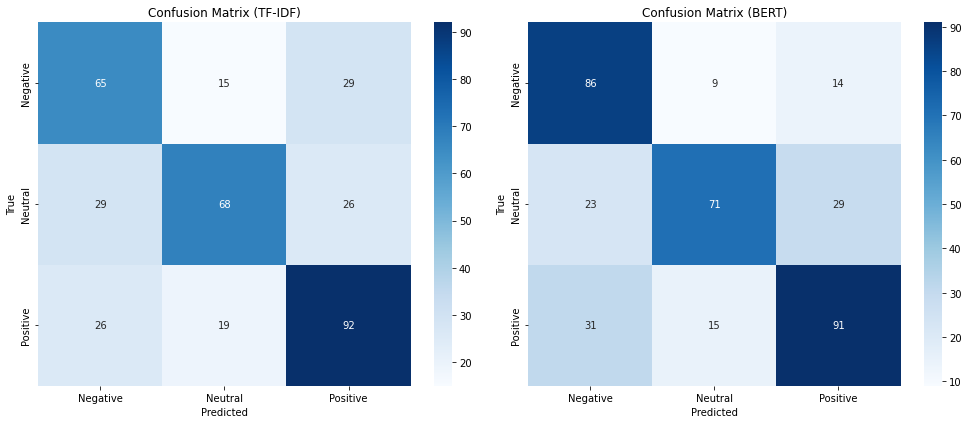

In [85]:
#Confusion Matrix Visualization (BERT vs TF-IDF)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(conf_matrix_tfidf, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
axes[0].set_title('Confusion Matrix (TF-IDF)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

sns.heatmap(conf_matrix_bert, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
axes[1].set_title('Confusion Matrix (BERT)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>

In [86]:
# Classification Reports
print("\nClassification Report (TF-IDF):")
print(classification_report_tfidf)



Classification Report (TF-IDF):
              precision    recall  f1-score   support

           0       0.54      0.60      0.57       109
           1       0.67      0.55      0.60       123
           2       0.63      0.67      0.65       137

    accuracy                           0.61       369
   macro avg       0.61      0.61      0.61       369
weighted avg       0.61      0.61      0.61       369



In [87]:

print("\nClassification Report (BERT):")
print(classification_report_bert)


Classification Report (BERT):
              precision    recall  f1-score   support

           0       0.61      0.79      0.69       109
           1       0.75      0.58      0.65       123
           2       0.68      0.66      0.67       137

    accuracy                           0.67       369
   macro avg       0.68      0.68      0.67       369
weighted avg       0.68      0.67      0.67       369

